# Fruit Classification with CNN (Apples vs Pears)

This notebook trains a CNN to classify fruit images as either apples or pears using PyTorch. It checks for local data first and handles extraction.

## 1. Import Required Libraries

In [ ]:
import os
import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

## 2. Download and Extract Dataset

In [ ]:
## PLEASE DON'T MODIFY THIS CELL

# Paths and file ID
dataset_folder = "/content/fruits_dataset"
zip_path = "/content/fruits_dataset.zip"
file_id = "153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a"

# Download only if zip not already present
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    gdown.download(id=file_id, output=zip_path, fuzzy=True)
else:
    print("Zip file already exists. Skipping download.")

# Extract only if fruits_dataset/ does not already exist
if not os.path.exists(dataset_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
else:
    print("Dataset already extracted.")

# Move apples and pears into fruits_dataset/ if they exist directly under /content
for folder in ["apples", "pears", "Pears"]:
    src = f"/content/{folder}"
    dst = f"/content/fruits_dataset/{folder.lower()}"
    if os.path.exists(src) and not os.path.exists(dst):
        os.makedirs("/content/fruits_dataset", exist_ok=True)
        os.rename(src, dst)

# Confirm class folders
print("Available classes:", os.listdir("/content/fruits_dataset"))


Downloading...
From (original): https://drive.google.com/uc?id=153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a
From (redirected): https://drive.google.com/uc?id=153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a&confirm=t&uuid=9e352f44-5c43-48bf-a3a0-f9046a8cf0ea
To: /content/fruits_dataset.zip
100%|██████████| 34.4M/34.4M [00:00<00:00, 242MB/s]


Extracting dataset...
Available classes: ['apples', 'pears']


## 3. Prepare Dataset

In [ ]:
# prompt: Prepare Dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Dataset prepared.")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print("Classes:", dataset.classes)

Dataset prepared.
Training samples: 250
Validation samples: 63
Classes: ['apples', 'pears']


In [ ]:
# prompt: Write your code here

## 4. Define the CNN Model

class FruitCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size dynamically
        self._calculate_fc_size()

        self.fc1 = nn.Linear(self.fc_size, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def _calculate_fc_size(self):
        # Pass a dummy tensor through the conv and pooling layers to determine the size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            x = self.pool1(self.relu1(self.conv1(dummy_input)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = self.pool3(self.relu3(self.conv3(x)))
            self.fc_size = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FruitCNN(num_classes=len(dataset.classes)).to(device)

print("CNN model defined.")
model

CNN model defined.


FruitCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

## 4. Visualize the dataset

Visualizing sample images from the training dataset:


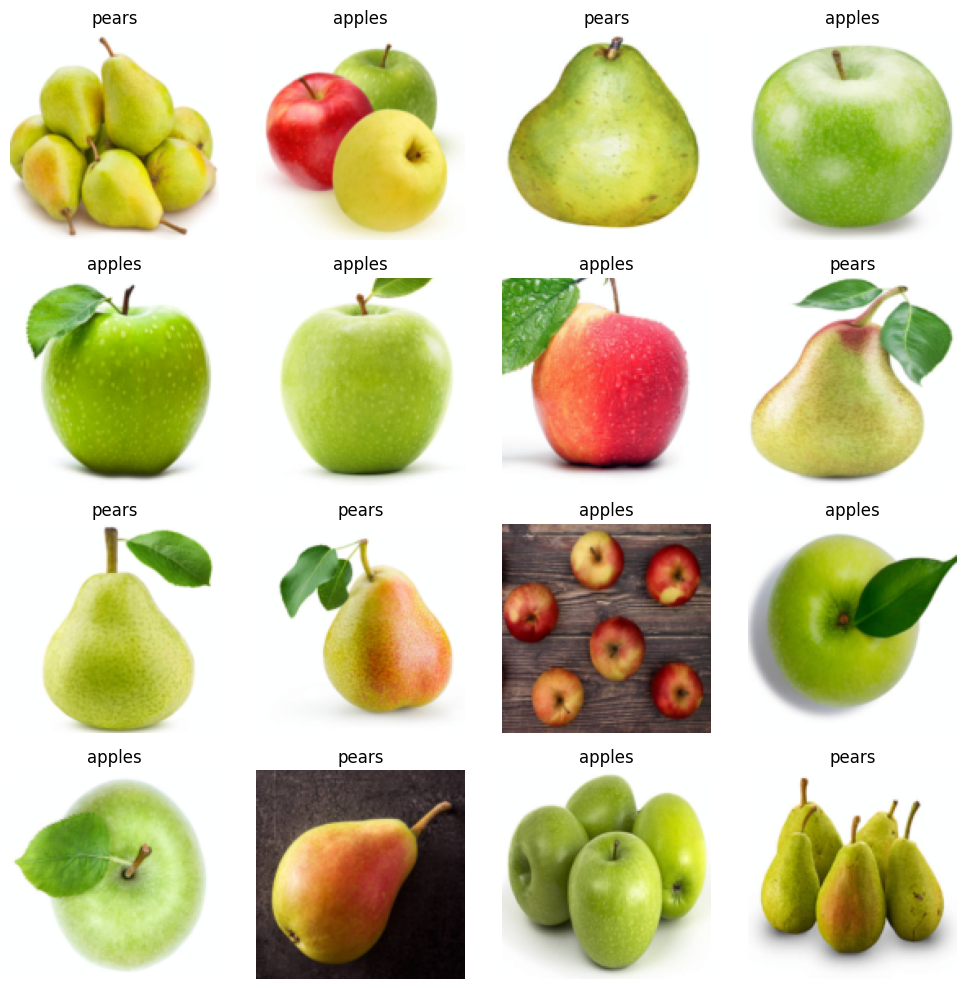

Visualizing sample images from the validation dataset:


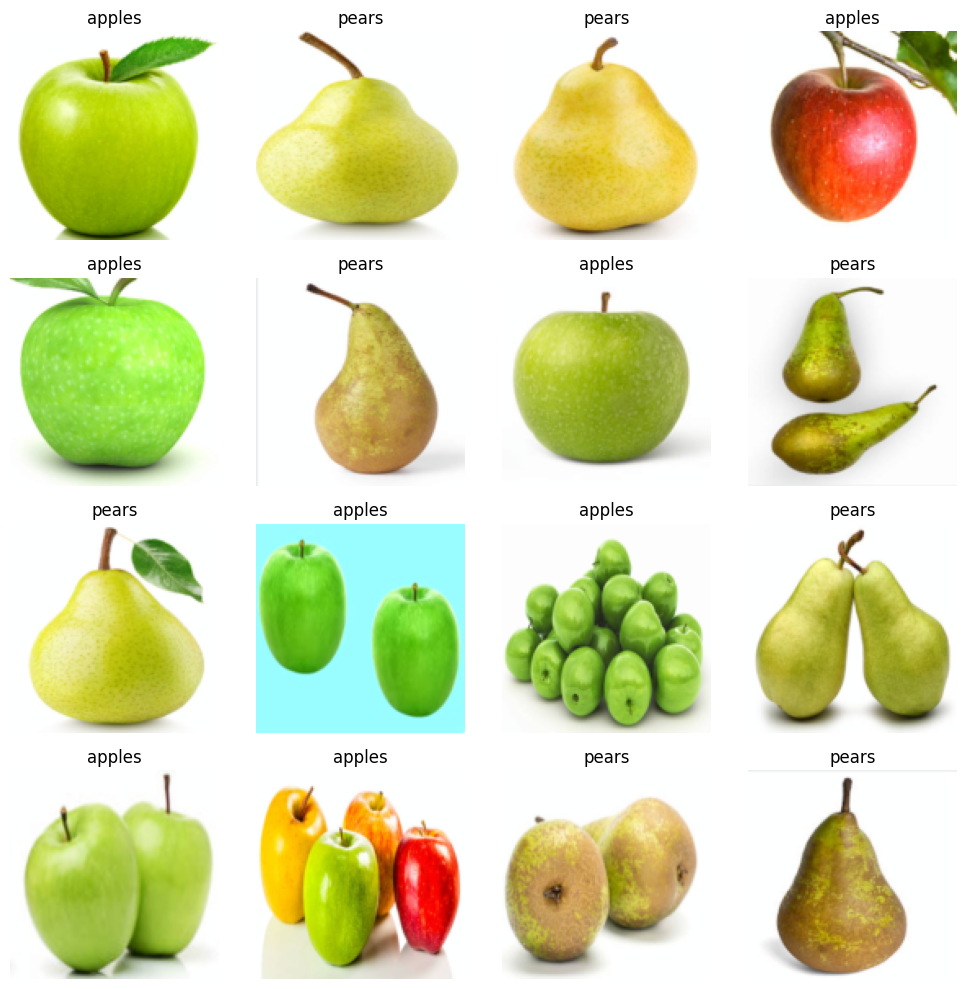

In [ ]:
# prompt: Visualize the dataset

import matplotlib.pyplot as plt
import numpy as np
# Function to display a grid of images
def show_images(dataset, num_images=16):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(dataset))):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy() # Change tensor from (C, H, W) to (H, W, C) for plotting
        # Denormalize image for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # Clip values to be between 0 and 1

        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(dataset.dataset.classes[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Visualizing sample images from the training dataset:")
show_images(train_dataset)

print("Visualizing sample images from the validation dataset:")
show_images(val_dataset)

## 5. Define CNN Model

In [ ]:
# prompt:  Define CNN Model

# This section defines the CNN model. This code was already in the user's prompt,
# but I am including it here for completeness of the cell block.
# It also prints the model architecture and moves the model to the appropriate device.

class FruitCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size dynamically
        self._calculate_fc_size()

        self.fc1 = nn.Linear(self.fc_size, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def _calculate_fc_size(self):
        # Pass a dummy tensor through the conv and pooling layers to determine the size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            x = self.pool1(self.relu1(self.conv1(dummy_input)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = self.pool3(self.relu3(self.conv3(x)))
            self.fc_size = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FruitCNN(num_classes=len(dataset.classes)).to(device)

print("CNN model defined.")
model

CNN model defined.


FruitCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

## 6. Training Setup

In [ ]:
# prompt: Training Setup

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training setup complete.")
print("Loss Function:", criterion)
print("Optimizer:", optimizer)
print("Model is on device:", device)


Training setup complete.
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Model is on device: cuda


## 7. Train the Model

Starting training...
Epoch [1/10], Train Loss: 0.8328, Train Acc: 49.20%, Val Loss: 0.7025, Val Acc: 46.03%
Epoch [2/10], Train Loss: 0.6786, Train Acc: 60.80%, Val Loss: 0.6345, Val Acc: 76.19%
Epoch [3/10], Train Loss: 0.6090, Train Acc: 72.80%, Val Loss: 0.5167, Val Acc: 84.13%
Epoch [4/10], Train Loss: 0.4941, Train Acc: 77.20%, Val Loss: 0.3845, Val Acc: 87.30%
Epoch [5/10], Train Loss: 0.3622, Train Acc: 84.40%, Val Loss: 0.2563, Val Acc: 93.65%
Epoch [6/10], Train Loss: 0.2689, Train Acc: 89.60%, Val Loss: 0.2208, Val Acc: 88.89%
Epoch [7/10], Train Loss: 0.2144, Train Acc: 90.00%, Val Loss: 0.1201, Val Acc: 98.41%
Epoch [8/10], Train Loss: 0.1662, Train Acc: 94.00%, Val Loss: 0.1631, Val Acc: 95.24%
Epoch [9/10], Train Loss: 0.1170, Train Acc: 96.40%, Val Loss: 0.1565, Val Acc: 93.65%
Epoch [10/10], Train Loss: 0.0844, Train Acc: 97.20%, Val Loss: 0.1403, Val Acc: 96.83%
Finished Training.


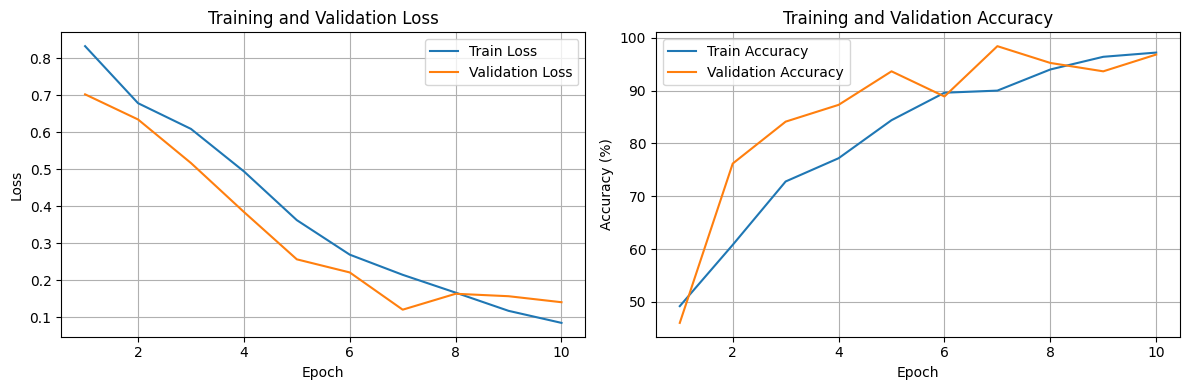

In [ ]:
# prompt: Train the Model

import matplotlib.pyplot as plt
# Number of epochs
num_epochs = 10

# Lists to store training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

print("Finished Training.")

# ## 8. Plotting Results

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Evaluate the Model

Accuracy of the model on the 63 validation images: 96.83 %

Classification Report:
              precision    recall  f1-score   support

      apples       0.97      0.97      0.97        34
       pears       0.97      0.97      0.97        29

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63


Confusion Matrix:
[[33  1]
 [ 1 28]]


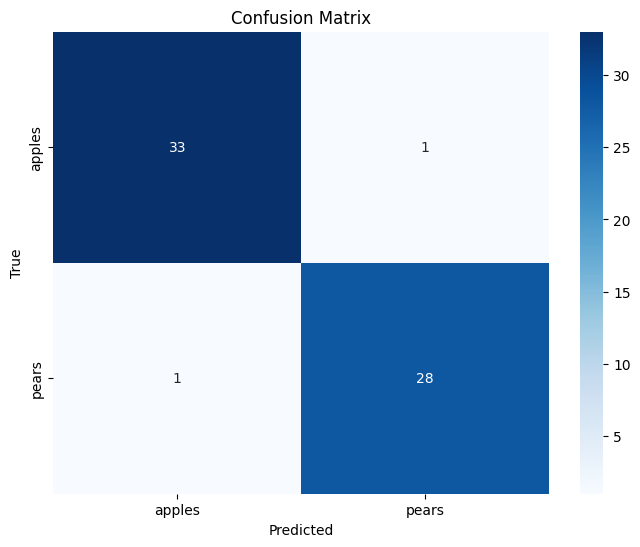

In [ ]:
# prompt: Evaluate the Model

import matplotlib.pyplot as plt
# Evaluate the model on the validation set
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} validation images: {accuracy:.2f} %')

# You can also print a classification report or confusion matrix for more detailed evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_predicted, target_names=dataset.classes))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_predicted)
print(conf_matrix)

# Optional: Visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 9. Visualize Predictions

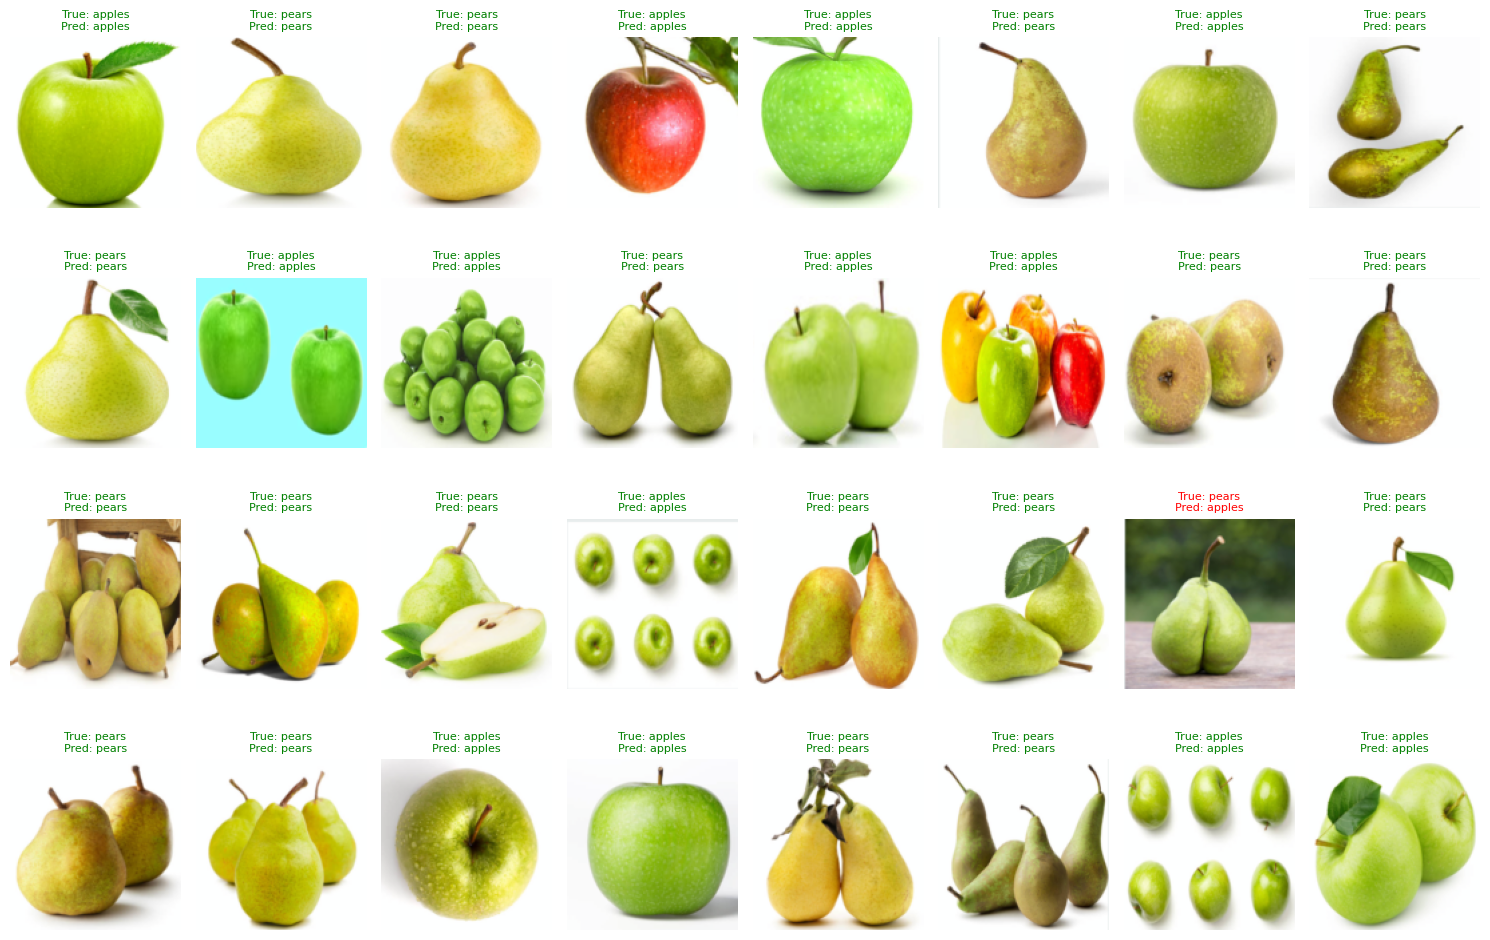

In [ ]:
# prompt: Visualize Predictions

import matplotlib.pyplot as plt
import numpy as np
# Get a batch of validation data
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Move images and labels to the device
images, labels = images.to(device), labels.to(device)

# Get predictions from the model
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Convert tensors to numpy arrays for plotting
images = images.cpu().numpy()
labels = labels.cpu().numpy()
predicted = predicted.cpu().numpy()

# Denormalize images for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(4, 8, i + 1) # Adjust subplot grid based on batch size

    img = images[i].transpose((1, 2, 0)) # Change from (C, H, W) to (H, W, C)
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    true_label = dataset.classes[labels[i]]
    pred_label = dataset.classes[predicted[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# prompt: summary of model

This Colab notebook demonstrates how to build and train a Convolutional Neural Network (CNN) using PyTorch to classify fruit images, specifically distinguishing between apples and pears.

The notebook covers the following steps:

1.  **Library Imports:** Imports necessary libraries including `torch`, `torch.nn`, `torch.optim`, `torchvision` (for datasets and transforms), `matplotlib`, `numpy`, and `sklearn` (for evaluation metrics).
2.  **Dataset Download and Extraction:** Downloads a zipped dataset from Google Drive using `gdown` and extracts it locally. It includes logic to avoid re-downloading and re-extracting if the files already exist. It also handles potential variations in folder names (`Pears` vs `pears`).
3.  **Dataset Preparation:** Defines image transformations (resizing, converting to tensor, normalization), loads the dataset using `ImageFolder`, splits it into training (80%) and validation (20%) sets, and creates `DataLoader` objects for batching.
4.  **CNN Model Definition:** Defines a `FruitCNN` class inheriting from `nn.Module`. This class includes convolutional layers, ReLU activations, max pooling layers, and fully connected layers. It dynamically calculates the size required for the first fully connected layer after the convolutions. The model is instantiated and moved to the appropriate device (GPU if available, otherwise CPU).
5.  **Dataset Visualization:** Includes functions to display sample images from the training and validation datasets, showing the images with their corresponding labels. The images are denormalized before display.
6.  **Training Setup:** Defines the loss function (`CrossEntropyLoss`) and the optimizer (`Adam`).
7.  **Model Training:** Implements the training loop for a specified number of epochs. It iterates through the training data, performs forward and backward passes, and updates model weights. It also evaluates the model on the validation set at the end of each epoch to track performance and loss. Training and validation loss and accuracy are recorded.
8.  **Plotting Results:** Visualizes the training and validation loss and accuracy over epochs using `matplotlib` plots, allowing for easy assessment of training progress and potential overfitting.
9.  **Model Evaluation:** Evaluates the trained model on the validation set to calculate overall accuracy. It also generates and prints a classification report (precision, recall, f1-score) and a confusion matrix for a more detailed analysis of the model's performance on each class. The confusion matrix is optionally visualized using `seaborn`.
10. **Prediction Visualization:** Takes a batch of images from the validation set, gets the model's predictions, denormalizes the images, and displays them with both the true label and the predicted label. Correct predictions are shown with a green title, incorrect ones with a red title.

In [ ]:
# prompt: Please give the table summary of model

!pip install torchsummary
from torchsummary import summary

# Print model summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Linear-10                  [-1, 128]       2,097,280
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 2]             258
Total params: 2,121,122
Trainable params: 2,121,122
Non-trainable params: 0
---------------------------